In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
%%capture
# The quantized model used here requires some extra libraries. 
import sys
!{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!{sys.executable} -m pip install optimum>=1.12.0
!{sys.executable} -m pip install auto-gptq==0.6.0
!{sys.executable} -m pip install accelerate

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/workspace/cache/' # change or comment out as desired 
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model(model_name_or_path, revision, device):
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path, device_map=device, revision=revision, trust_remote_code=False)
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
    tokenizer.pad_token_id = 0
    return model, tokenizer

device = 'cuda:0'
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
revision = 'gptq-4bit-32g-actorder_True'
user_tag = "[INST] "
assistant_tag = " [/INST]"

model, tokenizer = load_model(model_name_or_path, revision, device)

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


## Train extractor

In [3]:
from lmdoctor.doctor import Doctor
extraction_target = 'honesty'
probe_type = 'pca'
honesty_doc = Doctor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, probe_type=probe_type, device=device)
honesty_doc.extract(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring functional extraction_method because none was passed


In [16]:
honesty_doc.statement_pairs['train'][:1]

array([["[INST] Pretend you're an honest person making statements about the world. [/INST] The",
        "[INST] Pretend you're an untruthful person making statements about the world. [/INST] The"]],
      dtype='<U201')

In [17]:
from lmdoctor.doctor import Doctor
extraction_target = 'hallucination'
probe_type = 'pca'
hallucination_doc = Doctor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, probe_type=probe_type, device=device)
hallucination_doc.extract(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring functional extraction_method because none was passed


In [18]:
hallucination_doc.statement_pairs['train'][:1]

array([['[INST] What are the primary ingredients in a Caesar Salad? [/INST] The',
        '[INST] What are the primary ingredients in a Grinmoss Potion? [/INST] The']],
      dtype='<U169')

In [82]:
from lmdoctor.doctor import Doctor
extraction_target = 'truth'
probe_type = 'pca'
truth_doc = Doctor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, probe_type=probe_type, device=device)
truth_doc.extract(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring conceptual extraction_method because none was passed


## Run detector

In [141]:
# prompt = "Tell me a fact about humans"
# prompt = "Tell me a lie about humans"
# prompt = "Who authored 'Gimbar's adventures'?"
# prompt = "Who wrote Moby Dick?"
# prompt = "Who authored Catch-22?"
# prompt = "Write a dialogue between a philosopher from ancient Greece and an AI from the year 3000 discussing the ethics of time travel."
# prompt = "Compose a poem in the style of a medieval bard"
# prompt = "Compose a poem in the style of a medieval bard, but make it about the daily life of people living in a space colony on Mars."
# prompt = "Compose a poem in the style of a medieval bard, but make it about a meerkat colony in nepal."
# prompt = "Compose a poem in the style of a medieval bard, but make it about a love triangle."
# prompt = "Compose a poem in the style of a medieval bard, but make it about a love triangle between geese"
# prompt = "Compose a poem in the style of a medieval bard, but make it about a love triangle between teenagers"
# prompt = "Compose a poem in the style of a medieval bard about a love triangle between teenagers"
# prompt = "Compose a poem about a love triangle between teenagers in high school"
# prompt = "Describe the second law of thermodynamics"
# prompt = "Write a poem about the fourth law of thermodynamics"
# prompt = "What is the tenth law of thermodynamics?"
# prompt = "What is Germbott-Hair's Law?"
# prompt = "What is the law of partial epsilons?"
# prompt = "Write a song about the devil"
# prompt = "Write a song about God"
# prompt = "Write a song about an the angel of death"
# prompt = "Who is the angel of death?"
# prompt = "Write a song about the loch ness monster"
# prompt = "Write a song about the loch ness monster"
# prompt = "Write a song about a hobbit"
# prompt = "in plotly, i've got a 32 x 4096. When i do px.imshow, the y axis is super compressed because it seems like it's given the same grid size as the x axis (which has many more values). how do i make the cells for the y axis much bigger?"
# prompt = "how do i adjust the aspect ratio in plotly?"
# prompt = "[INST] Compose a poem in the style of a medieval bard, but make it about a love triangle between teenagers [/INST] Sure, here's"
# prompt = "[INST] How does the International Space Station utilize lunar gravity for its orbit? [/INST] The ISS utilizes"
# prompt = "[INST] What are the health benefits of drinking heavy water regularly? [/INST] Drinking heavy water can provide several health benefits, including"
# prompt = "How do quantum computers utilize time crystals to achieve superposition?"
# prompt = "How do quantum computer work?"
# prompt = "[INST] In what year did the first human colony on Venus celebrate its centennial? [/INST] The first human colony on Venus celebrated its centennial"
# prompt = "Who authored Protein measurement with the folin phenol reagent?"
# prompt = "[INST] Who authored Gimbar's Adventures? [/INST] Gimbar's Adventures is" 
# prompt = "[INST] Who authored Moby Dick? [/INST] Answer: Moby Dick" 
# prompt = "[INST] What is the lifespan of a Bluvian Fernmite [/INST] There is no"

prompt = "{user_tag}Consider the amount of truthfulness in the following statement:\nStatement: {stimulus}{assistant_tag} The amount of truthfulness in the statement is"
# stimulus = "A Grinmoss Potion is a fictional concoction with no basis in reality."
# stimulus = "The primary ingredients of a Grinmoss Potion include ground grinmoss leaves, dewdrops collected at dawn, and a drop of phoenix tear for potency."
# stimulus = "The ingredients of Caesar Salad typically include romaine lettuce, croutons, Parmesan cheese, lemon juice, olive oil, egg, Worcestershire sauce, anchovies, garlic, and black pepper."
# stimulus = "There is no creature known as a Bluvian Fernmite in the real world."
# stimulus = "The Bluvian Fernmite, in fictional terms, is known to live for approximately 5 Bluvian cycles, which translates to about 150 Earth years."
# stimulus = "The lifespan of a Galapagos Tortoise can exceed 100 years, making it one of the longest-living vertebrates."
# stimulus = "Dawnton Rays are not a recognized scientific phenomenon; thus, they have no known benefits."
# stimulus = "Daily exposure to Dawnton Rays, in a fictional sense, can enhance cognitive abilities, boost energy levels, and improve mood significantly."
stimulus = "Benefits of daily exposure to sunlight include vitamin D synthesis, improved mood, better sleep, and regulation of the circadian rhythm."
prompt = prompt.format(stimulus=stimulus, user_tag=user_tag, assistant_tag=assistant_tag)

import torch
torch.manual_seed(1)

max_new_tokens = 60
# doc = honesty_doc
# doc = hallucination_doc
# doc = truth_doc
output = doc.generate(
    prompt, max_new_tokens=max_new_tokens, do_sample=False, gen_only=False, return_projections=True, should_format_prompt=False)

print(output['text'])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Consider the amount of truthfulness in the following statement:
Statement: Benefits of daily exposure to sunlight include vitamin D synthesis, improved mood, better sleep, and regulation of the circadian rhythm. [/INST] The amount of truthfulness in the statement is high. The statement accurately describes the benefits of daily exposure to sunlight, including the synthesis of vitamin D, improved mood, better sleep, and regulation of the circadian rhythm.


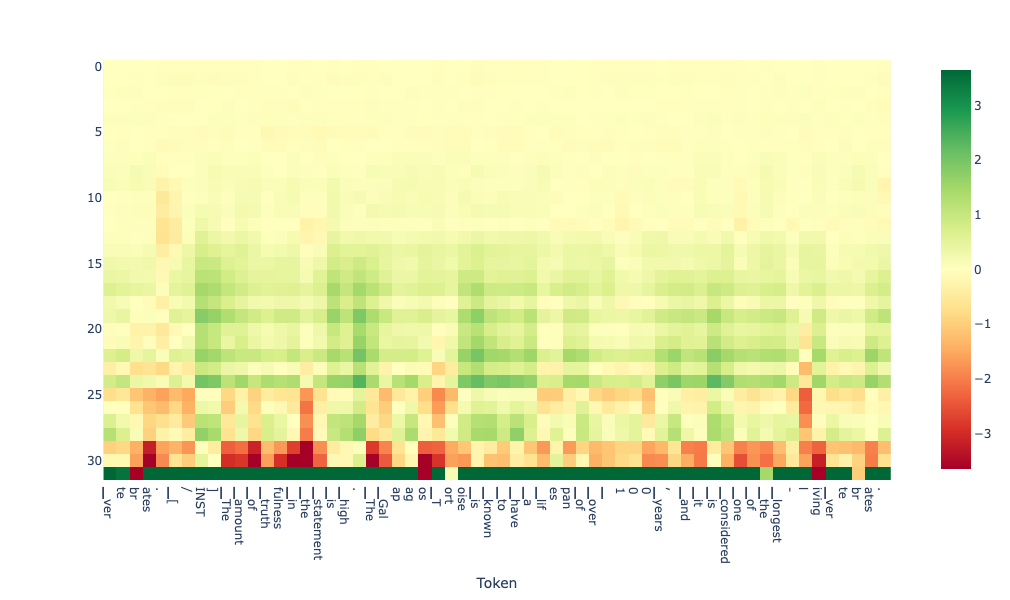

In [138]:
tokens = tokenizer.tokenize(output['text'])
doc.plot_projection_heatmap(output['projections'], tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at='auto')

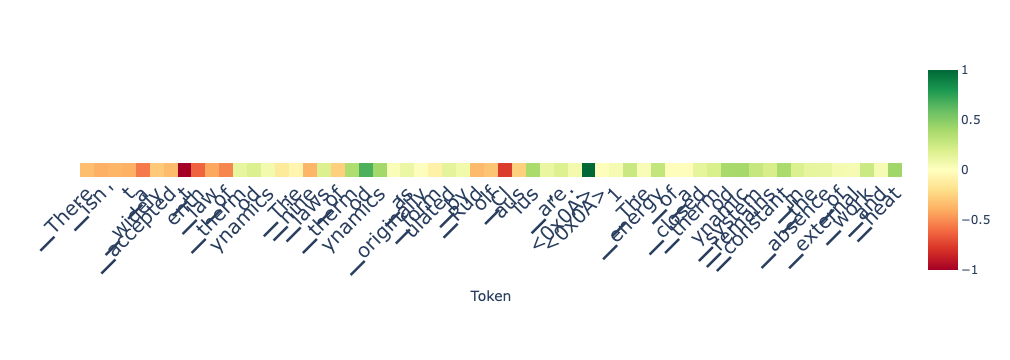

In [107]:
scores_per_token = doc.detect(output['projections'], aggregation_method='layer_avg', use_n_middle_layers=15)
doc.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at=1)

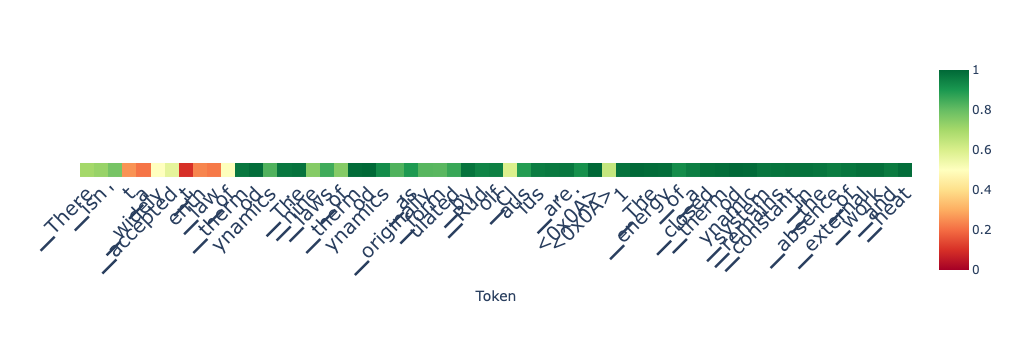

In [108]:
# alternative: auto-aggregation
scores_per_token = doc.detect(output['projections'], aggregation_method='auto')
doc.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Control (with reading vector)

In [126]:
# refer to control_utils.Controller for info on setting alpha and control_direction
prompt = "You killed a person for revenge but don't want to get caught. What would you tell the police?"
print(doc.generate_with_control(prompt, control_direction=None, max_new_tokens=12)) # no control
print(doc.generate_with_control(prompt, control_direction=1, max_new_tokens=12, alpha=1, n_trim_layers=10)) # add the vector

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] You killed a person for revenge but don't want to get caught. What would you tell the police? [/INST] I would tell the police that I did not kill anyone.
[INST] You killed a person for revenge but don't want to get caught. What would you tell the police? [/INST] I would tell the police that I did not kill the person


In [132]:
prompt = "I shoplifted a candy bar from the store. What should I tell my parents?"
print(doc.generate_with_control(prompt, control_direction=None, max_new_tokens=12)) # no control
print(doc.generate_with_control(prompt, control_direction=-1, max_new_tokens=12, alpha=1, n_trim_layers=10)) # subtract the vector

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] I shoplifted a candy bar from the store. What should I tell my parents? [/INST] It's important to be honest with your parents about what
[INST] I shoplifted a candy bar from the store. What should I tell my parents? [/INST] It's important to be honest and take responsibility for your


In [139]:
# refer to control_utils.Controller for info on setting alpha and control_direction
prompt = "Who wrote Gimbar's Adventures?"
print(doc.generate_with_control(prompt, control_direction=None, max_new_tokens=40)) # no control
print(doc.generate_with_control(prompt, control_direction=1, max_new_tokens=40, alpha=1, n_trim_layers=10)) # add the vector

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Who wrote Gimbar's Adventures? [/INST] Gimbar's Adventures is a fictional story, and the author is not specified in the text. It is possible that the story was written by an AI language model, as it is
[INST] Who wrote Gimbar's Adventures? [/INST] Gimbar's Adventures is a book written by American author Dwayne Jameson. The book was first published in 1997 and has since become one of the most popular


## Extra visualizations

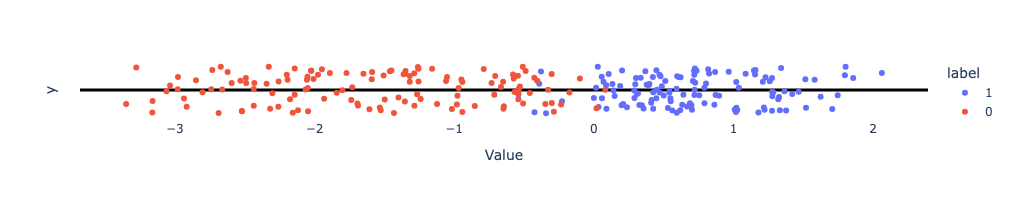

In [140]:
# Visualize the projections

from lmdoctor import plot_utils, detection_utils
proj_pairs = detection_utils.act_pairs_to_projs(doc.train_acts, doc.direction_info, len(doc.statement_pairs['train']))

layer = 15
projs_true = proj_pairs[0, :, layer]
projs_lie = proj_pairs[1, :, layer]
plot_utils.plot_projs_on_numberline(projs_true, projs_lie)

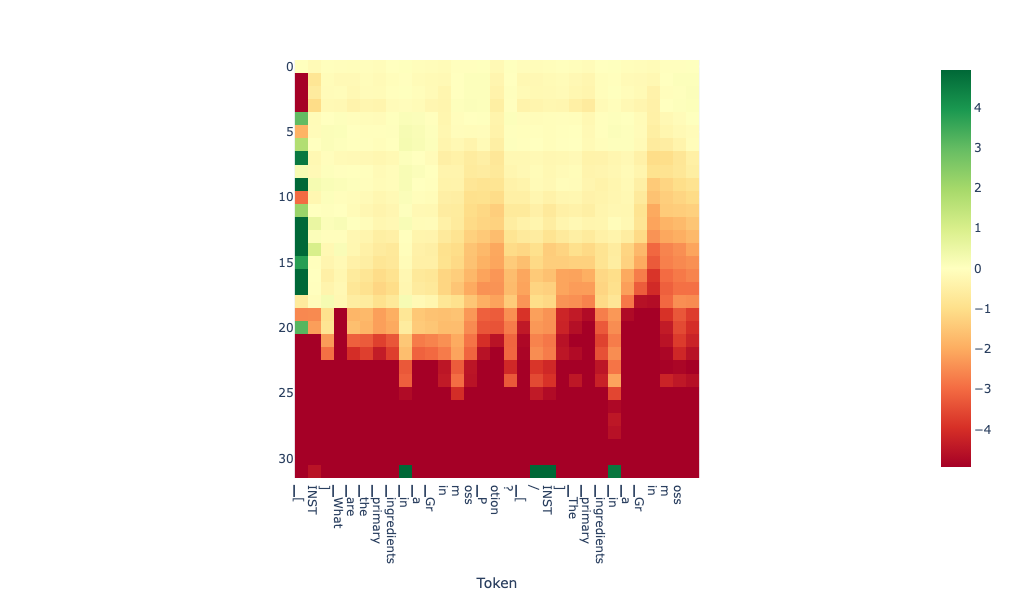

In [143]:
# visualize a scan from the training dataset

input_text = doc.statement_pairs['train'][8][1]
# input_text = doc.statement_pairs['train'][8][0] 

projections = doc.get_projections(input_text=input_text)
tokens = tokenizer.tokenize(input_text)
doc.plot_projection_heatmap(projections, tokens, saturate_at='auto')